# Parametrsation of gemmae contours


## Documentation and Imports


Created on 27-05-2021

Author: Valentin Laplaud

This code loads gemmae contours from ShapeComputation2.ipynb and express them as a function of a curvilinar abcisse. Adding landmark points (notches and attach points) then allows a deformation of the contour to match the position of landmark points.

In [1]:
# plotting stuff
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline

COLOR = 'white'
COLOR2 = 'black'

mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

mpl.rcParams["figure.facecolor"] = COLOR2
mpl.rcParams["axes.facecolor"] = COLOR2
mpl.rcParams["savefig.facecolor"] = COLOR2
mpl.rcParams['axes.facecolor'] = COLOR2

from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
from cycler import cycler
#Default colors
colorcycle = [plt.get_cmap('gist_rainbow')(1. * i/30) for i in range(30)]
mpl.rcParams['axes.prop_cycle'] = cycler(color=colorcycle)

# numbers handling
import numpy as np
import pandas as pd
    

# signal processing 
from scipy.signal import savgol_filter, correlate, correlation_lags, find_peaks
from scipy.interpolate import interp1d
from scipy import optimize

# images handling
from skimage import io
from skimage.filters import threshold_otsu, gaussian, laplace, sobel
from skimage.measure import label, regionprops, regionprops_table
from skimage.util import invert
from skimage.morphology import binary_opening, binary_closing, remove_small_holes,binary_erosion
from skimage.color import rgb2gray
from skimage.segmentation import active_contour
import cv2 as cv

# to hide known warnings
import warnings
warnings.filterwarnings("ignore")

# General system functions
import os
import shutil
import sys

import time

# my functions
sys.path.append('../')
import VallapFunc as vf



##  Define analysis functions

### Find drop and target centers
User input is used to identify points on the contours of both the drop and the impacted object. A circle is then fitted to those set of points and from the fitted circles, the centering of the drop is computed.

#### Identifiying contour points from user input.

In [2]:
def getContourPointsCoordinates(Img,Title, **kwargs):
    
     #init and read kwargs
    AddCircles = False
    
    for key, value in kwargs.items(): 
        if key == 'addcircles':
            AddCircles = value   
        elif key == 'circlespos':
            coords = value    
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')   
        
    # ask user to click
    %matplotlib qt
    fig,ax = plt.subplots(dpi=250)
    ax.imshow(Img,cmap='gray')
    if AddCircles:
        ax.plot(coords[0][0],coords[0][1],'r*')
        ax.plot(coords[1][0],coords[1][1],'g*')
    fig.suptitle(Title)
    pts = np.asarray(plt.ginput(n=-1, timeout=-1))
    plt.close()
    %matplotlib inline

    Xs = pts[:,0]
    Ys = pts[:,1]

    return(Xs,Ys)
 

#### Fitting circle to get the center

In [3]:
def fitCircle(X,Y):
    
    x_m = np.mean(X)
    y_m = np.mean(Y)    
    
    def calc_R(xc, yc):

        return np.sqrt((X - xc) ** 2 + (Y - yc) ** 2)
    
    def f_2(c):
        
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    
    center_estimate = x_m, y_m
    center_fit, _ = optimize.leastsq(f_2, center_estimate)

    xc_fit, yc_fit = center_fit
    Ri_fit       = calc_R(xc_fit, yc_fit)
    
     #Fitting the radius of the circle
    R_fit        = Ri_fit.mean()
   
    
    if False:
        fig,ax = plt.subplots(dpi=250, facecolor = 'black')
        ax.plot(X,Y,'ro')

        xcircle = xc_fit + R_fit*cos(np.linspace(-pi,pi,100))
        ycircle = yc_fit + R_fit*sin(np.linspace(-pi,pi,100))
        ax.plot(xcircle,ycircle,'k--')

    return([xc_fit, yc_fit,R_fit])
    


#### Compute drop centering

In [4]:
def DropCentering(P,StackList,Scale, **kwargs):     
    
    SD = pd.DataFrame(data=None,columns=['DropXc','DropYc','DropDiam','TargetXc','TargetYc','TargetDiam','OffCentering','OffCentering_pcDropDiam']) 
    
    #init and read kwargs
    DebugPlots = False
    
    for key, value in kwargs.items(): 
        if key == 'debug':
            DebugPlots = value  
        elif key == 'append':
            SD = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    for s in StackList:
        
        ImgD = io.imread(P + '\\Impacts\\' + s + '_Drop.tif') # get the  image from tiff stack
        ImgT = io.imread(P + '\\Impacts\\' + s + '_Target.tif') # get the  image from tiff stack
        
        TXs,TYs = getContourPointsCoordinates(ImgT,'Select on the contour of the target (enter button to validate)')
        DXs,DYs = getContourPointsCoordinates(ImgD,'Select on the contour of the drop (enter to validate)')
        
        dropCircle = fitCircle(DXs,DYs)
        targetCircle = fitCircle(TXs,TYs)
        
        dropXc = dropCircle[0]
        dropYc = dropCircle[1]
        dropR = dropCircle[2]
        
        targetXc = targetCircle[0]
        targetYc = targetCircle[1]
        targetR = targetCircle[2]
        
        OffC= np.sqrt(np.square(dropXc-targetXc)+np.square(dropYc-targetYc))
        OffCpc = OffC/dropR/2*100
        
        data = {'DropXc': dropXc,
            'DropYc': dropYc,
            'DropDiam': dropR*2/Scale,
            'TargetXc': targetXc,
            'TargetYc': targetYc,
            'TargetDiam': targetR*2/Scale,
            'OffCentering': OffC/Scale,
            'OffCentering_pcDropDiam': OffCpc} 

        SD = SD.append(pd.DataFrame(data=data,index = [s]))
        
        
            
        t = np.linspace(0,2*np.pi,1000)

        fig,ax = plt.subplots(dpi=300,facecolor='black')
        fig.suptitle('DropD : ' + str(round(dropR*2/Scale*10)/10) + ' mm. TargetD : ' +
                     str(round(targetR*2/Scale*10)/10) + ' mm. \nOffCent : ' + str(round(OffC/Scale*10)/10) + ' mm.' )
        plt.imshow(ImgD,cmap='gray')
        ax.plot(targetXc,targetYc,'.g',ms=2)
        ax.plot(targetXc+targetR*np.cos(t),targetYc+targetR*np.sin(t),'--g',lw=0.5)
        ax.plot(dropXc,dropYc,'.r',ms=2)
        ax.plot(dropXc+dropR*np.cos(t),dropYc+dropR*np.sin(t),'--r',lw=0.5)
        ax.plot([dropXc, targetXc],[dropYc,targetYc],'c',lw=0.2)
        ax.axis('off')      
        fig.savefig(P + '\\Impacts\\'+ s + '_Circles.png')
        
        if DebugPlots:
            plt.show()
        else:
            plt.close()
        
    return(SD)

### Find splash carac
Using snake active contour the shape of the splash is identified.
Fit a circle to splashes to find the theoretial center of impact. 

#### Remove droplets from image

In [5]:
def removeDroplets(Img):
    
    binImg = Img>threshold_otsu(Img)
    
    plt.imshow(binImg,cmap='gray')
    plt.show()
    
    labelImg = label(binImg)
    
    props = regionprops(labelImg)
    
    print(props)
    

#### Detect splash

In [6]:
def splashCarac(P,StackList,nimgs,SD,Scale, **kwargs):
    
    if not os.path.exists(P + '\\Splashes'):
            os.mkdir(P + '\\Splashes') # create global folder  
          
    
    #init and read kwargs
    DebugPlots = False
    
    for key, value in kwargs.items(): 
        if key == 'debug':
            DebugPlots = value                       
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    DD = pd.DataFrame(data=None)           
        
    for s in StackList:
        
        print('Analyzing ' + s + '...', end = '\r')
        
        if not os.path.exists(P + '\\Splashes\\' + s):
                os.mkdir(P + '\\Splashes\\' + s) # create global folder 
        
        SplashXcs = np.zeros(len(nimgs))
        SplashYcs = np.zeros(len(nimgs))        
        SplashRs = np.zeros(len(nimgs))
        
        for nimg,i in zip(nimgs,range(len(nimgs))): 
            
            print('Analyzing ' + s + '... Img ' + str(nimg), end = '\r')
        
            Img = io.imread(P + '\\' + s + '_Processed_Cut.tif', key=nimg) # get the  image from tiff stack

            DX = SD.loc[s,'DropXc']
            DY = SD.loc[s,'DropYc']
            DR = SD.loc[s,'DropDiam']/2*Scale

            TX = SD.loc[s,'TargetXc']
            TY = SD.loc[s,'TargetYc']
            TR = SD.loc[s,'TargetDiam']/2*Scale

            size = Img.shape

            ymax = size[1]
            xmax = size[0]

            npts = 50
            
            if (i == 0) | np.isnan(SplashRs[i-1]):
                side1 = np.array([np.linspace(0,xmax,npts), np.repeat([0],npts)])
                side2 = np.array([np.repeat([xmax],npts), np.linspace(0,ymax,npts)])
                side3 = np.array([np.linspace(xmax,0,npts), np.repeat([ymax],npts)])
                side4 = np.array([np.repeat([0],npts), np.linspace(ymax,0,npts)])

                init = np.concatenate((side1.T,side2.T, side3.T, side4.T))  
            else:
                t = np.linspace(0,2*np.pi,4*npts)
                Y = SplashXcs[i-1]
                X = SplashYcs[i-1]       
                R = SplashRs[i-1]*1.30*Scale
                init = np.array([X+R*np.cos(t), Y+R*np.sin(t)]).T
                
            
            snake = active_contour(Img,init, alpha=0.05, beta = 15, w_line=2, w_edge = 2)

            """
            alpha : float, optional
                Snake length shape parameter. Higher values makes snake contract faster.
    
            beta : float, optional
                Snake smoothness shape parameter. Higher values makes snake smoother.

            w_line : float, optional
                Controls attraction to brightness. Use negative values to attract toward dark regions.

            w_edge : float, optional
                Controls attraction to edges. Use negative values to repel snake from edges.
            """          
            SXs = snake[:,1]
            SYs = snake[:,0]
            
            
            ###### Faire de goodside un angle de 120+°
            GoodSide = np.sqrt(np.square(SXs-DX)+np.square(SYs-DY))>np.sqrt(np.square(SXs-TX)+np.square(SYs-TY))
            
            ##### Ajouté un tri pour ne prendre que les points assez proche du cercle précédents
            
            
            
            t = np.linspace(0,2*np.pi,200)

            fig, [ax1,ax2] = plt.subplots(ncols = 2,dpi=400)
            fig.suptitle('Circular fit on splash ' + s  +'_' + str(nimg))
            ax1.imshow(Img, cmap='gray')
            ax1.plot(init[:, 1], init[:, 0], '--r', lw=1)
            ax1.plot(snake[:, 1], snake[:, 0], '-b', lw=0.8)            
            ax1.axis([-5, Img.shape[1]+5, Img.shape[0]+5, -5])    
            ax1.set_xticks([])
            ax1.set_yticks([]) 
            ax1.set_title('Splash detection')
            ax2.imshow(Img,cmap='gray')
            ax2.plot(TX,TY,'.g',ms=2)
            ax2.plot(TX+TR*np.cos(t),TY+TR*np.sin(t),'--g',lw=0.5)
            ax2.plot(DX,DY,'.r',ms=2)
            ax2.plot(DX+DR*np.cos(t),DY+DR*np.sin(t),'--r',lw=0.5)
            ax2.plot(SXs[GoodSide],SYs[GoodSide],'*b',ms=0.1)
            ax2.axis([0, Img.shape[1], Img.shape[0], 0]) 
            ax2.set_xticks([])
            ax2.set_yticks([])
            
            if sum(GoodSide)>9:
                splashCircle = fitCircle(SXs[GoodSide],SYs[GoodSide])  
                SplashXcs[i] = splashCircle[0]
                SplashYcs[i] = splashCircle[1]        
                SplashRs[i] = splashCircle[2]/Scale                
                
                ax2.set_title('Fit circle to selected points')
                ax2.plot(splashCircle[0],splashCircle[1],'*c',ms=2)
                ax2.plot(splashCircle[0]+splashCircle[2]*np.cos(t),splashCircle[1]+splashCircle[2]*np.sin(t),'-c',lw=0.8)
                

                if DebugPlots:
                    plt.show()
                else:
                    plt.close()
                    
            else:
                SplashXcs[i] = np.nan
                SplashYcs[i] = np.nan   
                SplashRs[i] = np.nan
                ax2.set_title('Not enough points to fit')
                
               
            fig.savefig(P + '\\Splashes\\'+ s + '\\' + str(nimg) + '.png')   
                
        data = {'SplashXs': SplashXcs,
                    'SplashYs': SplashYcs,
                    'SplashRs': SplashRs,
                    'SplashTargetDist': vf.dist(SplashXcs,SplashYcs,TX,TY)/Scale,
                    'SplashDropDist': vf.dist(SplashXcs,SplashYcs,DX,DY)/Scale,
                    'frames': nimgs
                   }

        DD = DD.append(pd.DataFrame(data=data,index = np.repeat(s,len(SplashXcs))))
        
        
        print('Analyzing ' + s + '... Done.'.ljust(10), end = '\n')
        
        OffC = SD.loc[s,'OffCentering_pcDropDiam']
        fig0, [ax01,ax02] = plt.subplots(ncols=2,dpi=300,facecolor='black')
        fig0.suptitle(s + ' - OffC = ' + str(round(OffC*10)/10) + '%')
        DD.loc[s].plot(x='frames',y='SplashRs',ax=ax01,style='bo-',legend=None)
        ax01.set_ylabel('Splash radius (mm)')    
        ax01.set_xlabel('Frames since impact')
        DD.loc[s].plot(x='frames',y='SplashTargetDist',ax=ax02,style='go-',legend=None)
        ax02.set_ylabel('Splash center distance from target (mm)')  
        ax02.set_xlabel('Frames since impact')     
        plt.tight_layout()
        fig0.savefig(P210702 + '\\Splashes\\'+ s + '_SplashCarac.png')
        
    return(DD)
            

##  Enter data and run

### Data details

In [12]:
###### Experiment of the 21-06-2021, P/C-CO-D3 with lab prints from the 14/04, 3mm diam, 12mm height
# Spatial scale (px/mm)
Scale210621 = 11.34  
# Frames per second
FPS210621 = 10000 
# Paths to data
P210621 = r'D:\Users\laplaud\Desktop\PostDoc\Data\SplashCups\2021.06.21'
# List of videos to analyze
StackList210621 = ['CC0_D3_1','CC0_D3_2','CC0_D3_3','CC0_D3_4','CC0_D3_5',
                  'CC0_D3_6','CC0_D3_7','CC0_D3_8','CC0_D3_9','CC0_D3_10',
                  'PC0_D3_1','PC0_D3_2','PC0_D3_3','PC0_D3_4','PC0_D3_5',
                  'PC0_D3_6','PC0_D3_7','PC0_D3_8','PC0_D3_9','PC0_D3_10'] 

###### Experiment of the 02-07-2021, P/C-CO-D3 with lab prints from the 14/04, 3mm diam, 12mm height
# Spatial scale (px/mm)
Scale210702 = 11.20 
# Frames per second
FPS210702 = 10000 
# Paths to data
P210702 = r'D:\Users\laplaud\Desktop\PostDoc\Data\SplashCups\2021.07.02'
# List of videos to analyze
StackList210702 = ['PC0_1','PC0_2','PC0_3','PC0_4','PC0_5','PC0_6','PC0_7','PC0_8','PC0_9','PC0_10',
                      'PC0_11','PC0_12','PC0_13','PC0_14','PC0_15','PC0_16','PC0_17','PC0_18','PC0_19','PC0_20',
                       'PC0_21','PC0_22',
                       'CC0_1','CC0_2','CC0_3','CC0_4','CC0_5','CC0_6','CC0_7','CC0_8','CC0_9','CC0_10',
                        'CC0_11','CC0_12','CC0_13','CC0_14','CC0_15','CC0_16','CC0_17','CC0_18','CC0_19','CC0_20',
                        'CC0_21','CC0_22','CC0_23','CC0_24','CC0_25']

SplashList210702 = ['PC0_1','PC0_3','PC0_6','PC0_11','PC0_15','PC0_16','PC0_18','PC0_19','PC0_21',
                    'CC0_1','CC0_6','CC0_7','CC0_12','CC0_13','CC0_15','CC0_16','CC0_17','CC0_18',
                    'CC0_19','CC0_21','CC0_22','CC0_24',]


Scale210721 = 10.89 
# Frames per second
FPS210721 = 10000 
# Paths to data
P210721 = r'D:\Users\laplaud\Desktop\PostDoc\Data\SplashCups\2021.07.21'
# List of videos to analyze
StackList210721 = ['MCC0_45-7'] 


print('Data choice made.')

Data choice made.


### Run 

#### Drop centers

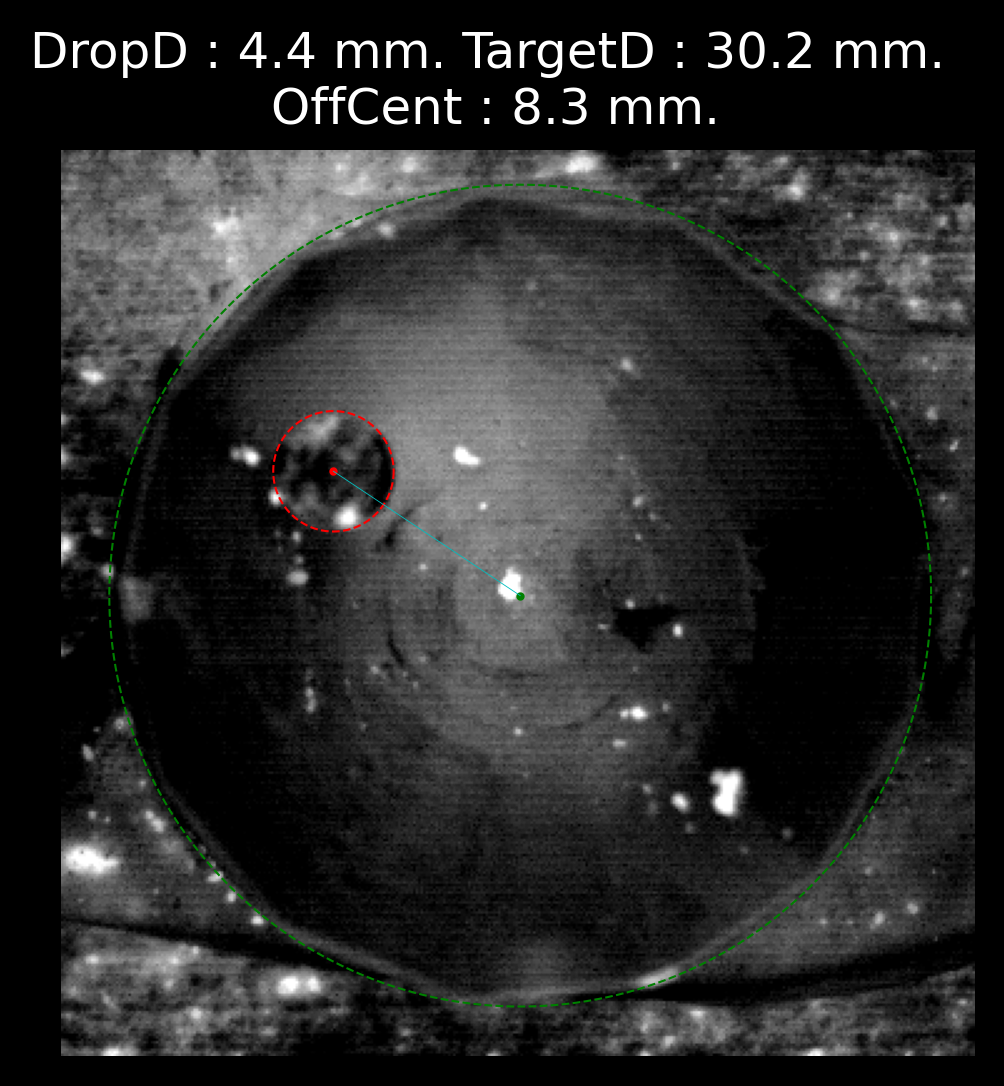

In [13]:
#SplashData210621 = DropCentering(P210621,StackList210621,Scale210621, debug=True)
#SplashData210702 = DropCentering(P210702,StackList210702,Scale210702, debug=True)

SplashData210721 = pd.read_csv(P210721 + '\\SplashData210721_Circles.csv',index_col = 'Ind')
SplashData210721 = DropCentering(P210721,StackList210721,Scale210721, debug=True, append=SplashData210721)

In [14]:
##### Intermediary saving
#SplashData210621.to_csv(P210621 + '\\SplashData210621_Circles.csv',index_label = 'Ind')
#SplashData210702.to_csv(P210702 + '\\SplashData210702_Circles.csv',index_label = 'Ind')
SplashData210721.to_csv(P210721 + '\\SplashData210721_Circles.csv',index_label = 'Ind')

#### Splash centering

In [10]:
##### Intermediary loading
SplashData210621 = pd.read_csv(P210621 + '\\SplashData210621_Circles.csv',index_col = 'Ind')
SplashData210702 = pd.read_csv(P210702 + '\\SplashData210702_Circles.csv',index_col = 'Ind')

In [11]:
bla
DynamicData210702 = splashCarac(P210702,SplashList210702,np.arange(5,50),SplashData210702,Scale210702, debug = False)


NameError: name 'bla' is not defined

### Saving

In [ ]:
#DynamicData210621.to_csv(P210702 + '\\DynamicData210621.csv',index_label = 'Ind')
DynamicData210702.to_csv(P210702 + '\\DynamicData210702.csv',index_label = 'Ind')

## Test Zone

In [ ]:
splashList = np.unique(DynamicData210702.index)
for s in splashList:


    
fig1,ax1 = plt.subplots(dpi=300,facecolor='black')    
for s in splashList:
    OffC = SplashData210702.loc[s,'OffCentering_pcDropDiam']
    sheetSpeed = np.mean(np.divide(
        np.diff(DynamicData210702.loc[s,'SplashRs']),np.diff(DynamicData210702.loc[s,'frames'])))*FPS210702/1000
    ax1.plot(OffC,sheetSpeed,'bo')
    ax1.set_xlabel('Off centering (% drop size)')
    ax1.set_ylabel('Average sheet expansion speed (m/s)')

In [ ]:
Img = io.imread(P210702 + '\\PC0_3_Processed_Cut.tif', key=26)
plt.figure(dpi=300)
plt.imshow(Img,cmap='gray')
plt.show()

removeDroplets(Img)